In [ ]:
pip install scikit-posthocs

In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import stats
import scikit_posthocs as sp

### Import files

In [12]:
#import filenames
files = pd.read_csv(r'path to filenames csv', skiprows=8)
dictionary = pd.Series(files.filename.values,index=files.file_id).to_dict()
files.head()

,file_id,filename,is_good
0,0,/DATA/network_drive/Tracking_Data/Iris/global_...,True
1,1,/DATA/network_drive/Tracking_Data/Iris/global_...,False
2,2,/DATA/network_drive/Tracking_Data/Iris/global_...,True
3,3,/DATA/network_drive/Tracking_Data/Iris/global_...,True
4,4,/DATA/network_drive/Tracking_Data/Iris/global_...,True


In [13]:
feat = pd.read_csv(r'path to features csv', skiprows=1)

#get filenames
feat['filename']= feat['file_id'].map(dictionary)

#get strain names, based on the first 6 characters of the filename
strain = []
file = []
for p in feat['filename']:
    a = os.path.basename(p)
    b = a[0:6]
    strain.append(b)
    file.append(a)
feat['strain']= strain
feat['file']= file

#make a unique index for each worm 'video_index'
feat['unique_worm_index'] = feat['file'] + '_' + feat['worm_index'].astype(str)

feat.head()

,file_id,worm_index,n_skeletons,blob_compactness_w_forward_IQR,curvature_mean_midbody_norm_abs_IQR,motion_mode_paused_duration_50th,relative_to_tail_base_radial_velocity_tail_tip_w_forward_50th,d_curvature_std_midbody_abs_90th,speed_head_tip_norm_IQR,eigen_projection_3_abs_90th,...,speed_head_tip_w_backward_50th,angular_velocity_midbody_w_forward_abs_50th,d_curvature_mean_hips_w_backward_abs_IQR,blob_hu3_10th,curvature_std_neck_norm_abs_10th,filename,strain,file,video_timepoint,unique_worm_index
0,0,1,1222.0,0.008171,1.801119,2.000050,0.001840,0.086838,0.052604,2.955428,...,NaN,0.423209,NaN,0.000403,1.426392,/DATA/network_drive/Tracking_Data/Iris/global_...,AQ5242,AQ5242_global_40to45_26nov21_1_featuresN.hdf5,45,AQ5242_global_40to45_26nov21_1_featuresN.hdf5_1
1,0,2,6728.0,0.011175,2.567212,1.260031,0.010214,0.102617,0.089538,4.117849,...,-11.406294,0.595140,0.096452,0.000582,1.165673,/DATA/network_drive/Tracking_Data/Iris/global_...,AQ5242,AQ5242_global_40to45_26nov21_1_featuresN.hdf5,45,AQ5242_global_40to45_26nov21_1_featuresN.hdf5_2
2,0,3,6332.0,0.011145,2.469489,1.120028,0.013931,0.114795,0.138071,3.889261,...,-12.864178,0.635961,0.171569,0.000481,1.197763,/DATA/network_drive/Tracking_Data/Iris/global_...,AQ5242,AQ5242_global_40to45_26nov21_1_featuresN.hdf5,45,AQ5242_global_40to45_26nov21_1_featuresN.hdf5_3
3,0,4,6004.0,0.015117,2.159254,0.600015,0.020846,0.112626,0.157337,3.578213,...,-12.308079,0.487129,0.166430,0.000420,1.211324,/DATA/network_drive/Tracking_Data/Iris/global_...,AQ5242,AQ5242_global_40to45_26nov21_1_featuresN.hdf5,45,AQ5242_global_40to45_26nov21_1_featuresN.hdf5_4
4,0,5,3836.0,0.013284,1.932065,0.940023,0.006390,0.098601,0.089787,3.272520,...,-14.223466,0.454542,0.156339,0.000448,1.186739,/DATA/network_drive/Tracking_Data/Iris/global_...,AQ5242,AQ5242_global_40to45_26nov21_1_featuresN.hdf5,45,AQ5242_global_40to45_26nov21_1_featuresN.hdf5_5


In [14]:
#how many trajectories per strain?
feat['strain'].value_counts()

AQ5241    159
alh-11    126
AQ5235    118
AQ5242    115
N2___g    108
lgc-41     83
Name: strain, dtype: int64

In [15]:
feat_means = feat.groupby(['strain','video_timepoint']).mean()
feat_means.head()

file_id  worm_index  n_skeletons  \
strain video_timepoint                                       
AQ5235 45                8.313433   18.656716  5422.373134   
       5                 2.843137   20.666667  5303.000000   
AQ5241 25               16.000000   20.700000  5398.550000   
       45               20.236111   25.527778  5005.083333   
       5                15.910448   37.328358  4736.716418   

                        blob_compactness_w_forward_IQR  \
strain video_timepoint                                   
AQ5235 45                                     0.012589   
       5                                      0.013698   
AQ5241 25                                     0.013500   
       45                                     0.013703   
       5                                      0.015081   

                        curvature_mean_midbody_norm_abs_IQR  \
strain video_timepoint                                        
AQ5235 45                                          2.035155   
       5                                           2.079690   
AQ5241 25                                          2.160055   
       45                                          2.328067   
       5                                           2.338479   

                        motion_mode_paused_duration_50th  \
strain video_timepoint                                     
AQ5235 45                                       0.904195   
       5                                        0.647067   
AQ5241 25                                       0.701000   
       45                                       0.863343   
       5                                        0.695526   

                        relative_to_tail_base_radial_velocity_tail_tip_w_forward_50th  \
strain video_timepoint                                                                  
AQ5235 45                                                        0.001010               
       5                                                         0.016944               
AQ5241 25                                                        0.012878               
       45                                                        0.009466               
       5                                                         0.013126               

                        d_curvature_std_midbody_abs_90th  \
strain video_timepoint                                     
AQ5235 45                                       0.098180   
       5                                        0.106171   
AQ5241 25                                       0.109531   
       45                                       0.101655   
       5                                        0.116868   

                        speed_head_tip_norm_IQR  eigen_projection_3_abs_90th  \
strain video_timepoint                                                         
AQ5235 45                              0.100300                     3.380963   
       5                               0.194420                     3.207090   
AQ5241 25                              0.114571                     3.340215   
       45                              0.112317                     3.468946   
       5                               0.224562                     3.305782   

                        ...  curvature_std_neck_w_backward_abs_10th  \
strain video_timepoint  ...                                           
AQ5235 45               ...                                0.018728   
       5                ...                                0.017058   
AQ5241 25               ...                                0.019019   
       45               ...                                0.019485   
       5                ...                                0.017843   

                        blob_hu1_w_backward_90th  \
strain video_timepoint                             
AQ5235 45                               0.423109   
       5                                0.404958   
AQ5241 25

In [46]:
#make a list of strains to analyse and plot
strains_touse = ['N2___g', 'lgc-41', 'alh-11']

#make a list of basic locomotion features
basic_features = ['strain','motion_mode_forward_fraction','motion_mode_backward_fraction',
                  'speed_10th', 'speed_50th']

['strain',
 'motion_mode_forward_fraction',
 'motion_mode_backward_fraction',
 'speed_10th',
 'speed_50th']

In [59]:
#select timepoint of interest
newdata = feat.loc[feat['strain'].isin(strains_touse)]
feat_plot = newdata.loc[:,basic_features]

feat_plot.head()

,strain,motion_mode_forward_fraction,motion_mode_backward_fraction,speed_10th,speed_50th
392,N2___g,0.819030,0.178896,-15.162889,13.842403
393,N2___g,0.808791,0.186495,-12.231820,10.072509
394,N2___g,0.647125,0.319121,-11.351700,5.203160
395,N2___g,0.808914,0.168348,-9.690004,10.977256
396,N2___g,0.688337,0.253725,-13.295677,6.993820


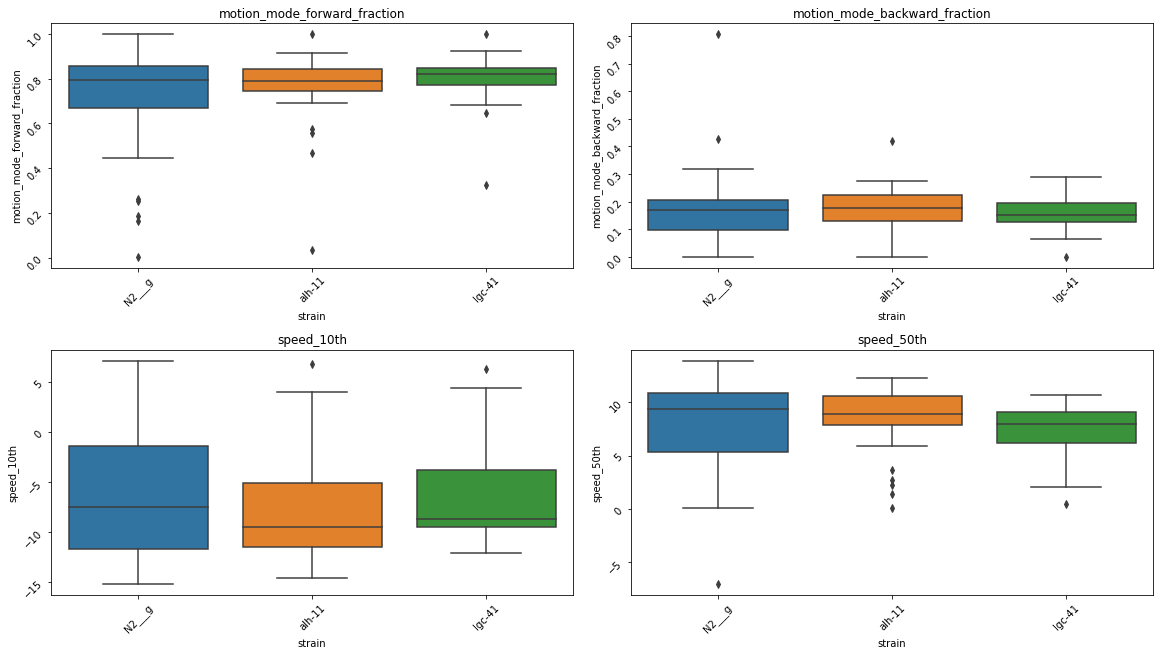

In [61]:
maxc = 2 #number of rows in the grid
maxr = 2 #number of cols in the grid

h = 9 #height in inches 
w = 16 #width in inches 

a=0
b=0

# Initialise the subplot function using number of rows and columns
fig, axes = plt.subplots(maxc, maxr, figsize=(w, h), sharey=False, constrained_layout = True)
#fig.suptitle('Title')

for col in feat_plot:
    if col != 'strain':
        sns.boxplot(ax=axes[a, b], x=feat_plot.strain, y=feat_plot[col])
        axes[a,b].set_title(col)
        axes[a,b].tick_params(labelrotation=45)
        b = b+1
        if b > maxr-1:
            a = a+1
            b = 0
            
plt.savefig(r'new fig path')

In [62]:
#make a list of strains
strain_list = feat_plot.strain.unique()
key=[]
values_k=[]
values_d=[]
kruskal_result = {}
dunn_bonferroni_result={}

for col in feat_plot:
    if col != 'strain':
        group1 = newdata.query('strain == "N2___g"')[col]
        group2 = newdata.query('strain == "lgc-41"')[col]
        group3 = newdata.query('strain == "alh-11"')[col]
        key.append(col)
        values_k.append(stats.kruskal(group1, group2, group3))
        all_data = [group1, group2, group3]
        #perform Dunn's test using a Bonferonni correction for the p-values
        values_d.append(sp.posthoc_dunn(all_data, p_adjust = 'bonferroni'))
        
for i in range(len(key)):
    kruskal_result[key[i]] = values_k[i]
    dunn_bonferroni_result[key[i]] = values_d[i]
    
for key, value in dunn_bonferroni_result.items():
    print(key)
    print(value)

motion_mode_forward_fraction
         1        2    3
1  1.00000  0.69267  1.0
2  0.69267  1.00000  1.0
3  1.00000  1.00000  1.0
motion_mode_backward_fraction
          1         2         3
1  1.000000  1.000000  0.501354
2  1.000000  1.000000  0.471352
3  0.501354  0.471352  1.000000
speed_10th
          1         2         3
1  1.000000  1.000000  0.659865
2  1.000000  1.000000  0.172014
3  0.659865  0.172014  1.000000
speed_50th
         1         2         3
1  1.00000  0.039780  1.000000
2  0.03978  1.000000  0.060685
3  1.00000  0.060685  1.000000
